In [21]:
# Libaries used
import warnings
import numpy as np
import seaborn as sns
import pandas as pd
from pathlib import Path

import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_ccf
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.structural import UnobservedComponents
from collections import defaultdict

import optuna
import joblib
import shap
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, recall_score, precision_score, f1_score, roc_curve
from sklearn.utils import resample
from sklearn.inspection import permutation_importance

<h1>Initial Data Preprocessing</h1>

<h2>Loading and Cleaning Data</h2>

In [2]:
def load_and_clean_cases(df):
    drop_cols = [
        "adm_1_name", "adm_2_name", "FAO_GAUL_code", "IBGE_code",
        "ISO_A0", "S_res", "UUID", "RNE_iso_code",
        "adm_0_name", "full_name", "Year", "calendar_end_date",
        "case_definition_standardised"
    ] 
    
    df = df.drop(columns=drop_cols, errors="ignore")
    df = df[df["T_res"] != "Year"] # Keep only Weekly results, excluding yearly totals
    df = df.drop("T_res",axis=1)
    df = df.rename(columns={"calendar_start_date": "date"})
    df = df.rename(columns={"dengue_total": "dengue_cases"})
    df["date"] = pd.to_datetime(df["date"])
    df.reset_index(drop=True,inplace=True)
    return df

# Importing dengue cases
dengue_df_2011_2021 = pd.read_csv("data/dengue_2011_2021.csv") # Data is not included 
dengue_df_2022_2024 = pd.read_excel("data/dengue_2022_2024.xlsx") # Data is not included 

dengue_df_2011_2021 = load_and_clean_cases(dengue_df_2011_2021) # Dropping and renaming columns
dengue_df_2011_2021  = dengue_df_2011_2021 .query("date >= '2011-01-01' and date <= '2021-12-31'")

start_date = pd.to_datetime("2022-01-02") # Start date of 2022_2024 dengue dataset

dengue_df_2022_2024['date'] = pd.date_range(start=start_date, periods=len(dengue_df_2022_2024), freq='W-SUN') # Assigning date for 2022-2024 dataset starting from Sunday
dengue_df_2022_2024 = dengue_df_2022_2024.rename(columns={"Cases":"dengue_cases"})

In [3]:
# Importing Daily Weather Features
BASE_DIR = Path("data/weather/west_malaysia") # Assigning path for weather varibles 

years = range(2011, 2025)
files = {
    "precipitation": ("Precipitate_Sel", "Precipitate"),
    "temperature": ("Temperature_Sel", "Temperature"),
    "humidity": ("Humidity_Sel", "Humidity"),
    "windspeed": ("Windspeed_Sel", "Wind speed"),
}

weather_df = []

for year in years:
    for var, (folder, fname) in files.items():
        path = BASE_DIR / folder / "West Malaysia" / f"{fname} {year}.csv"

        df = pd.read_csv(path, skiprows=9)

        df = df.rename(columns=str.lower)

        df = df.rename(columns={
            "prectotcorr": "value",
            "t2m": "value",
            "rh2m": "value",
            "ws2m": "value"
        })

        df["year"] = year
        df["variable"] = var

        weather_df.append(df)

weather_df = pd.concat(weather_df, ignore_index=True)
weather_df =(
    weather_df
    .pivot_table(
        index=["year", "doy"],
        columns="variable",
        values="value",
        aggfunc="mean"
    )
    .reset_index()
)

<h2>Preparation of Dataframe & Filling missing values</h2>

In [4]:
# Checking missing data in dengue df
dengue_df_2011_2021.isna().sum()

date            0
dengue_cases    0
dtype: int64

In [5]:
dengue_df_2022_2024[dengue_df_2022_2024['dengue_cases'].isna()].groupby('Year').size()

Year
2022     5
2023     1
2024    17
dtype: int64

In [6]:
# Using interpolation to fill in 2023 missing values as there's only 1 missing data in 2023
mask_2023 = dengue_df_2022_2024["Year"] == 2023

dengue_df_2022_2024.loc[mask_2023, "dengue_cases"] = (
    dengue_df_2022_2024
    .loc[mask_2023, "dengue_cases"]
    .interpolate(method="linear", limit=1)
)

In [7]:
# Cleaning missing data values in 2022 using Kalman smoothing due to 5 missing values some of which are missing in consecutive rows
# Building a local linear trend
Kalman_model = UnobservedComponents(dengue_df_2022_2024["dengue_cases"], level='local level', trend=True)

Kalman_result = Kalman_model.fit() # Fitting model

# Using the smoothed state estimates
Kalman_values = Kalman_result.smoothed_state[0]

# Added to Kalman results to the 2022-2024 dengue DF
dengue_df_2022_2024["cases_kalman"] = Kalman_values

# Replacing missing values with Kalman-filled ones
dengue_df_2022_2024["dengue_cases"] = dengue_df_2022_2024["dengue_cases"].fillna(dengue_df_2022_2024["cases_kalman"])
dengue_df_2022_2024 = dengue_df_2022_2024.drop(['cases_kalman','Year'],axis=1)

dengue_df_2022_2024["dengue_cases"] = (dengue_df_2022_2024["dengue_cases"].round().astype(int)) # Rounding up dengue cases values since kalman values has decimals

Value of `trend` may be overridden when the trend component is specified using a model string.


In [8]:
# Assigning date for the weather df
dates = pd.date_range(start='2011-01-01', end='2024-12-31')

weather_df['date']=dates

weather_df.drop(['year','doy'], axis=1,inplace=True)

weather_df.reset_index(drop=True,inplace=True)

weather_df.columns.name = None

In [9]:
agg_dict = {
    'temperature':         'mean',  
    'humidity':            'mean',  
    'precipitation':       'sum', 
    'windspeed':           'mean',
}

# Aggregating the weather variables from days to weeks
weather_df = weather_df.set_index("date")
weather_df = weather_df.resample('W-MON').agg(agg_dict)
weather_df.index = weather_df.index - pd.Timedelta(days=1)

In [10]:
# Combining 2011-2021 and 2022-2024 dengue data
cases_2011_2024 = pd.concat([dengue_df_2011_2021,dengue_df_2022_2024],ignore_index=True)

# Merging both Weather data and dengue case
Weather_Case = pd.merge(weather_df, cases_2011_2024, on='date')

<h1>EDA</h1>

Text(2023-10-01 00:00:00, 3952.6174999999994, 'Validation')

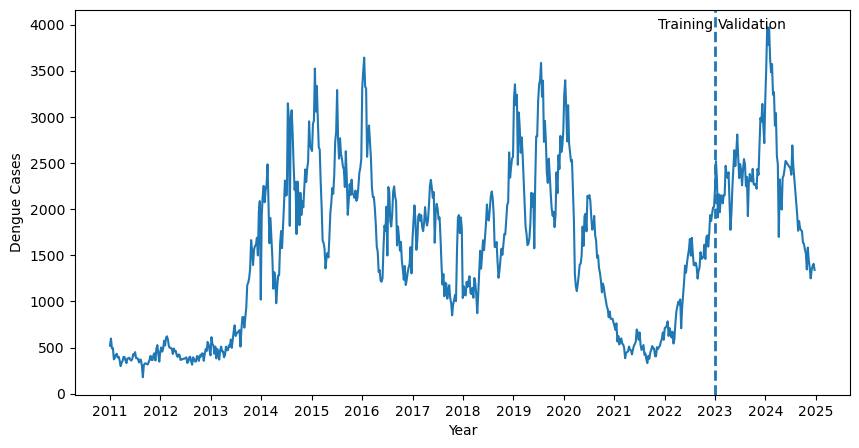

In [11]:
# Visualizing the training and validation data frame split
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(Weather_Case['date'], Weather_Case['dengue_cases']) # Set X and Y axis as date and dengue cases, respectively

ax.set_xlabel("Year")
ax.set_ylabel("Dengue Cases")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Shows years only instead, avoid cluttering with date and month

# Training period
ax.axvline(
    pd.Timestamp("2023-01-01"),
    linestyle='--',
    linewidth=2,
    label="Train / Validation split"
)

ax.text(
    pd.Timestamp("2022-06-01"),
    ax.get_ylim()[1]*0.95,
    "Training",
    ha='center'
)

# Validation period
ax.text(
    pd.Timestamp("2023-10-01"),
    ax.get_ylim()[1]*0.95,
    "Validation",
    ha='center'
)

In [12]:
Weather_Case.dtypes

date             datetime64[ns]
temperature             float64
humidity                float64
precipitation           float64
windspeed               float64
dengue_cases              int64
dtype: object

In [13]:
# Checking Variance of dengue cases for the need of negative binomial on GAM
mean_val = np.mean(Weather_Case['dengue_cases'])
var_val = np.var(Weather_Case['dengue_cases'])

print("Mean:", mean_val)
print("Variance:", var_val)

if var_val > mean_val:
    print("Dengue cases variance is greater than the mean, suggesting potential overdispersion.") # Uses negative binomial
else:
    print("Dengue cases variance is close to or less than the mean, suggesting no overdispersion issue (or underdispersion).") # Consider poisson distribution GAM

Mean: 1563.9532324621732
Variance: 758301.1284868002
Dengue cases variance is greater than the mean, suggesting potential overdispersion.


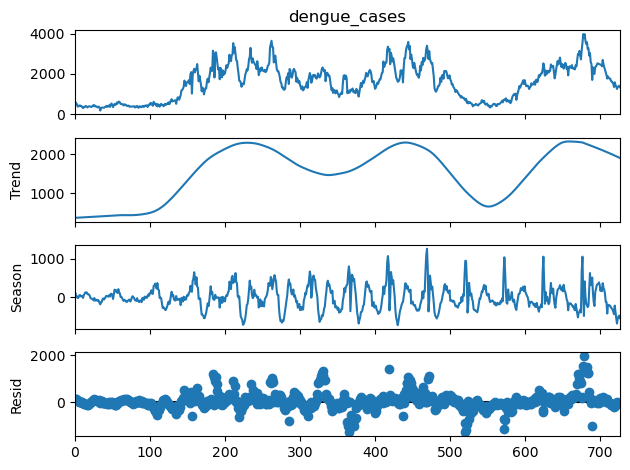

<Figure size 640x480 with 0 Axes>

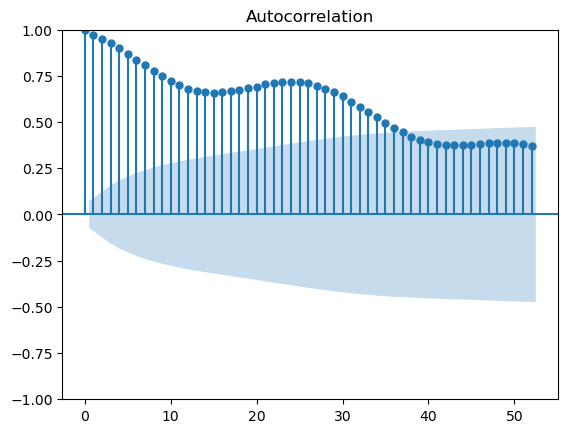

In [14]:
# Checking the seasonality, residual and autocorrelation of dengue cases
stl_cases = STL(Weather_Case['dengue_cases'], period=52, robust=True).fit()
fig = stl_cases.plot()
plt.show()

plt.figure()
plot_acf(Weather_Case['dengue_cases'], lags=52)
plt.show()

In [15]:
# Export to detrend dengue cases using Generative Additive Model (GAM) with Negative binomial in R Studio
Weather_Case.to_csv('Weather_Case.csv', index=False)

In [16]:
# The new Weather + Dengue case dataframe that contains the dengue residuals
New_WC = pd.read_csv("C:/Users/User/Documents/Dengue Project/Dengue Cases/Resid_Weather_Case.csv")

In [17]:
New_WC.drop(['t','Unnamed: 0'],axis=1, inplace=True) # Get rid of unnecessary columns made after GAM modeling

In [18]:
New_WC

,date,temperature,humidity,precipitation,windspeed,dengue_cases,cases_resid
0,2011-01-02,27.026667,83.863333,24.50,2.636667,520,0.972176
1,2011-01-09,26.254286,83.880000,54.35,1.731429,597,1.894535
2,2011-01-16,26.342857,82.900000,32.61,2.390000,490,0.718296
3,2011-01-23,26.870000,76.774286,14.59,1.555714,494,0.807621
4,2011-01-30,26.305714,83.660000,115.96,2.032857,371,-0.581766
...,...,...,...,...,...,...,...
722,2024-11-24,27.878571,81.731429,128.16,1.797143,1249,-0.547754
723,2024-12-01,27.420000,85.494286,91.28,2.418571,1342,-0.089696
724,2024-12-08,27.787143,81.764286,30.33,2.155714,1384,0.197665
725,2024-12-15,27.811429,83.248571,28.21,3.061429,1407,0.423427


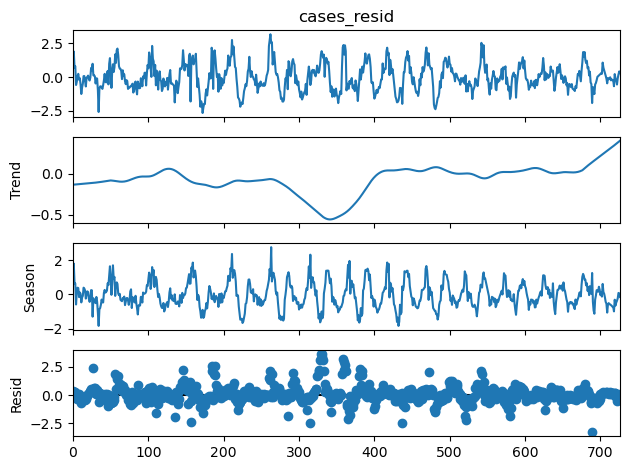

<Figure size 640x480 with 0 Axes>

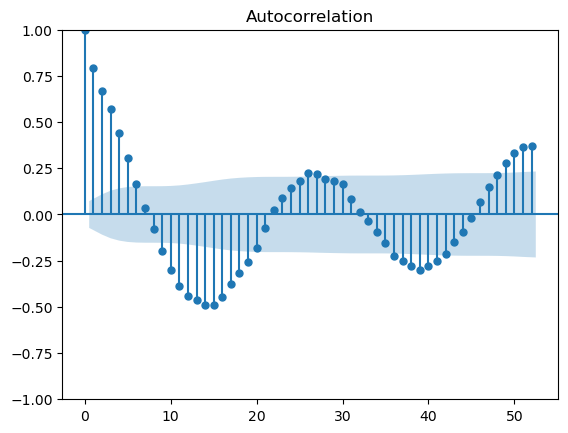

In [19]:
# Rechecking whether autocorrelation and seasonality is lessened or not
stl_resid_cases = STL(New_WC['cases_resid'], period=52, robust=True).fit()
fig = stl_resid_cases.plot()
plt.show()

plt.figure()
plot_acf(New_WC['cases_resid'], lags=52)
plt.show()

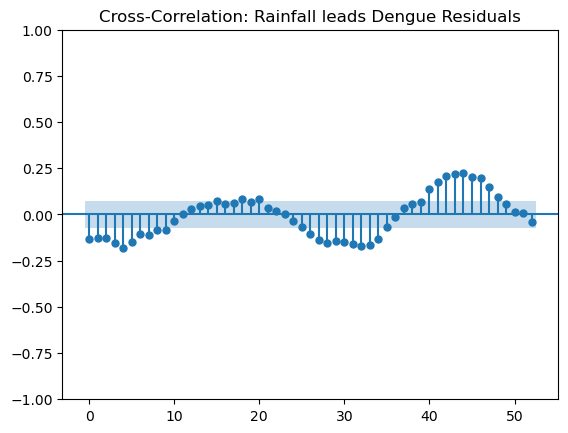

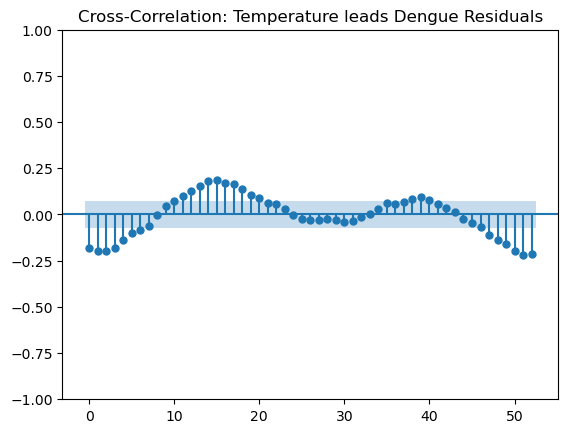

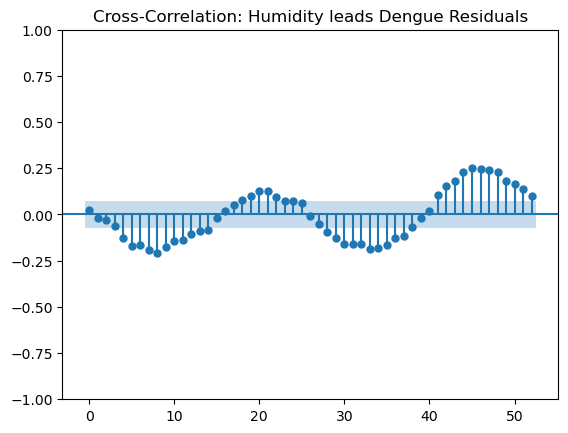

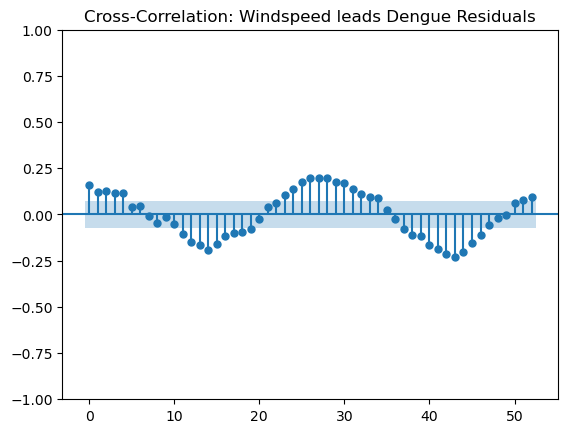

In [22]:
# Checking the correlation between lag 0-52 weather variables and residual dengue cases to find potential lags to use
plot_ccf(New_WC['precipitation'], New_WC['cases_resid'],lags=52)
plt.title("Cross-Correlation: Rainfall leads Dengue Residuals")
plt.show()

plot_ccf(New_WC['temperature'], New_WC['cases_resid'],lags=52)
plt.title("Cross-Correlation: Temperature leads Dengue Residuals")
plt.show()

plot_ccf(New_WC['humidity'], New_WC['cases_resid'],lags=52)
plt.title("Cross-Correlation: Humidity leads Dengue Residuals")
plt.show()

plot_ccf(New_WC['windspeed'], New_WC['cases_resid'],lags=52)
plt.title("Cross-Correlation: Windspeed leads Dengue Residuals")
plt.show()

<h1>Modelling</h1>

<h2>Baseline Model</h2>

Baseline: auc         0.692389
pr_auc      0.645657
sens        0.715877
prec        0.558362
f1_score    0.610160
dtype: float64
Running fold 1 / 5 for SHAP...
Running fold 2 / 5 for SHAP...
Running fold 3 / 5 for SHAP...
Running fold 4 / 5 for SHAP...
Running fold 5 / 5 for SHAP...

Aggregated SHAP importance (mean |SHAP| across folds):
             feature  mean_abs_shap  sd_abs_shap
0  dengue_cases_lag1       1.999981     0.656828
1  dengue_cases_lag6       1.478607     0.646315
2  dengue_roll_min_2       1.036525     0.364835
3  dengue_cases_lag4       0.965083     0.514169


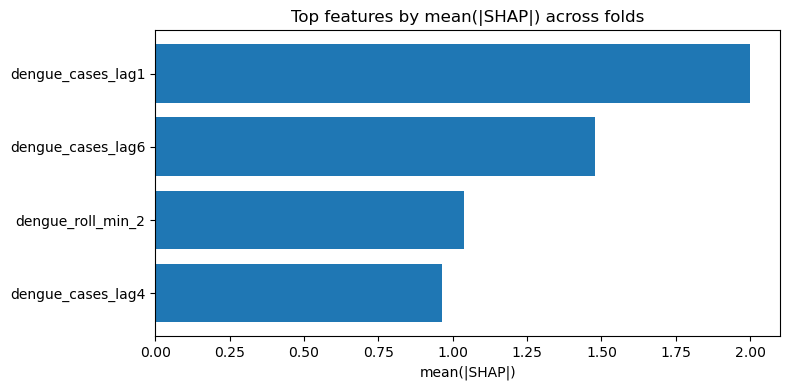

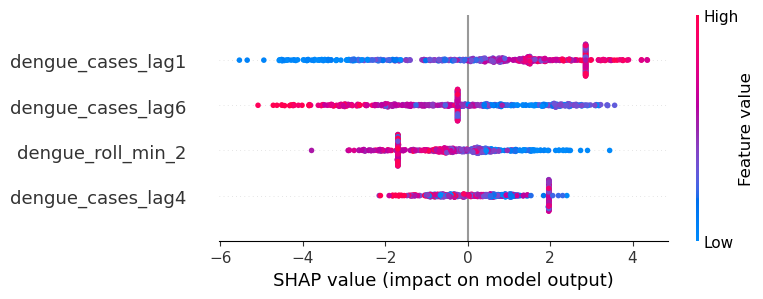

In [23]:
df_lagged = New_WC.copy() # Create a separate copy of the dataframe to be used in modelling

df_lagged = df_lagged[df_lagged['date'] < '2023-01-01']

warnings.filterwarnings('ignore')

# Defining outbreak
df_lagged['q75_4w'] = df_lagged['dengue_cases'].rolling(window=4, min_periods=1).quantile(0.75).shift(1) # shift(1) so label uses *past* window only (no peeking)
df_lagged['outbreak'] = (df_lagged['dengue_cases'] > df_lagged['q75_4w']).astype(int)

def make_lag_features(df, target_col, max_lag):
    df = df.copy()
    for lag in range(1, max_lag + 1):
        df[f"{target_col}_lag{lag}"] = df[target_col].shift(lag)

    return df

df_lagged = make_lag_features(df_lagged, 'dengue_cases', 6)

windows = [2,3]  # in weeks

for w in windows:
    df_lagged[f'dengue_roll_max_{w}']  = df_lagged['dengue_cases_lag1'].rolling(window=w).max()
    df_lagged[f'dengue_roll_max_{w}']  = df_lagged['dengue_cases_lag1'].rolling(window=w).max()
    df_lagged[f'dengue_roll_min_{w}']  = df_lagged['dengue_cases_lag1'].rolling(window=w).min()
    df_lagged[f'dengue_roll_min_{w}']  = df_lagged['dengue_cases_lag1'].rolling(window=w).min()
    df_lagged[f'dengue_roll_std_{w}']  = df_lagged['dengue_cases_lag1'].rolling(window=w).std()
    df_lagged[f'dengue_roll_std_{w}']  = df_lagged['dengue_cases_lag1'].rolling(window=w).std()

df_lagged.dropna(inplace=True)
df_lagged = df_lagged[df_lagged['date'] >= '2012-01-01']

X = df_lagged.copy()
y = df_lagged['outbreak'].values

# Rolling Origin Cross validation function, outputs model's metrics
def rolling_eval(X, y, model_builder, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    metrics = []
    for train_idx, test_idx in tscv.split(X): # Splits dataset according to current split, with a total of 5 splits
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model = model_builder()
        model.fit(X_train, y_train)
        prob = model.predict_proba(X_test)[:,1]
        # compute metrics
        aucroc = roc_auc_score(y_test, prob) 
        precision, recall, _ = precision_recall_curve(y_test, prob) # Precision-recall AUC
        pr_auc = auc(recall, precision)
        pred = (prob>0.5).astype(int)  # Threshold of when a week would be classified as an outbreak by the model
        sens = recall_score(y_test, pred)
        prec = precision_score(y_test, pred, zero_division=0)
        f1 = f1_score(y_test,pred, zero_division=0)
        metrics.append({'auc':aucroc, 'pr_auc':pr_auc, 'sens':sens, 'prec':prec, 'f1_score':f1})
    return pd.DataFrame(metrics).mean()

# Model
def build_xgb():
    return xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

baseline_df = df_lagged[['dengue_cases_lag4','dengue_cases_lag1','dengue_cases_lag6','dengue_roll_min_2']] # Selected baseline dengue variables
print('Baseline:', rolling_eval(baseline_df, y, build_xgb)) # Printing baseline metrics
fold_metrics_df=rolling_eval(baseline_df, y, build_xgb)

tscv = TimeSeriesSplit(n_splits=5)
mean_abs_shap_per_feat = defaultdict(list)
all_shap_samples = []
all_X_samples = []

for fold_index, (train_idx, val_idx) in enumerate(tscv.split(baseline_df)):
    print(f"Running fold {fold_index+1} / 5 for SHAP...")
    X_train, X_val = baseline_df.iloc[train_idx], baseline_df.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    m = build_xgb()
    m.fit(X_train, y_train)

    # TreeExplainer for XGBoost (for SHAP)
    explainer = shap.TreeExplainer(m)

    # Sample validation rows for speed; use fold_index as random_state for reproducibility
    Xs = X_val.copy()

    # Compute SHAP values
    try:
        sv = explainer.shap_values(Xs)   # Older API may return list per class
        sv_pos = sv[1] if isinstance(sv, list) else sv
    except Exception: 
        # Newer API returns an Explanation object via explainer(X), but this only matters if the older API does not work
        exp = explainer(Xs)
        # exp.values might be (n_samples, n_features) or (n_samples, n_classes, n_features)
        if hasattr(exp, "values"):
            vals = exp.values
            # if vals has 3 dims (n_samples, n_classes, n_features), pick positive class
            if vals.ndim == 3:
                sv_pos = vals[:,1,:]
            else:
                sv_pos = vals
        else:
            raise

    sv_arr = np.array(sv_pos)  # (n_samples, n_features)

    # Mean absolute shap per feature for this fold
    mean_abs = np.abs(sv_arr).mean(axis=0)
    for feat, val in zip(Xs.columns, mean_abs):
        mean_abs_shap_per_feat[feat].append(val)

    # Collect samples for combined beeswarm later
    all_shap_samples.append(sv_arr)
    all_X_samples.append(Xs)

# Aggregate results across folds
agg = []
for feat, vals in mean_abs_shap_per_feat.items():
    agg.append({'feature': feat, 'mean_abs_shap': np.mean(vals), 'sd_abs_shap': np.std(vals)})
agg_df = pd.DataFrame(agg).sort_values('mean_abs_shap', ascending=False)

print("\nAggregated SHAP importance (mean |SHAP| across folds):")
print(agg_df.reset_index(drop=True).head(20))

# Plot bar chart of top features
top_n = min(20, len(agg_df))
plt.figure(figsize=(8, max(4, top_n*0.3)))
plt.barh(agg_df['feature'][:top_n][::-1], agg_df['mean_abs_shap'][:top_n][::-1])
plt.xlabel('mean(|SHAP|)')
plt.title('Top features by mean(|SHAP|) across folds')
plt.tight_layout()
plt.show()

# Combined beeswarm (concatenate samples)
X_cat = pd.concat(all_X_samples, axis=0)
sv_cat = np.vstack(all_shap_samples)  # shape should be (total_samples, n_features)
# Ensure columns order matches
assert list(X_cat.columns) == list(baseline_df.columns), "Column order mismatch; shap array must align with X_cat.columns"

# Beeswarm summary
shap.summary_plot(sv_cat, X_cat, show=True)

<h2>Weather Model</h2>

Baseline: auc         0.692389
pr_auc      0.645657
sens        0.715877
prec        0.558362
f1_score    0.610160
dtype: float64
Weather Model: auc         0.709470
pr_auc      0.624087
sens        0.771048
prec        0.586029
f1_score    0.651777
dtype: float64
Running fold 1 / 5 for SHAP...
Running fold 2 / 5 for SHAP...
Running fold 3 / 5 for SHAP...
Running fold 4 / 5 for SHAP...
Running fold 5 / 5 for SHAP...

Aggregated SHAP importance (mean |SHAP| across folds):
               feature  mean_abs_shap  sd_abs_shap
0    dengue_cases_lag1       1.293490     0.305064
1    dengue_cases_lag6       1.253477     0.582693
2  precipitation_roll5       0.843932     0.212476
3    dengue_cases_lag4       0.772428     0.463546
4     temperature_lag6       0.677634     0.035488
5    dengue_roll_min_2       0.536259     0.103104


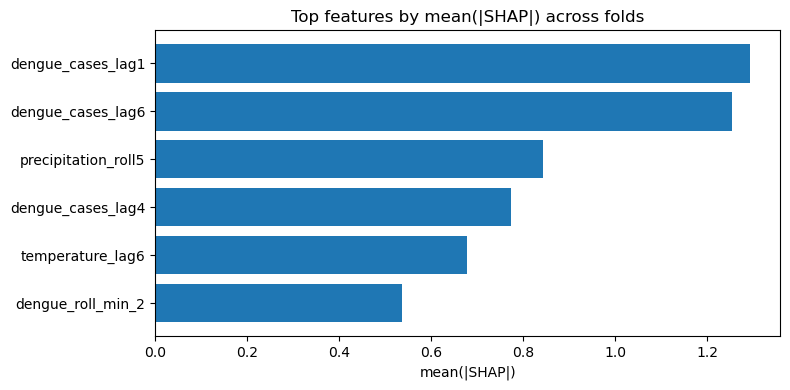

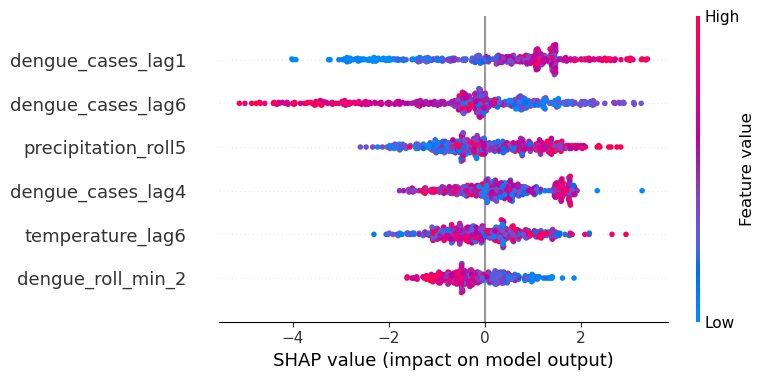

In [24]:
df_lagged = New_WC.copy() # Create a separate copy of the dataframe to be used in modelling

df_validation = df_lagged[(df_lagged['date'] >= '2023-01-01') & (df_lagged['date'] <= '2024-05-05')]
df_lagged = df_lagged[df_lagged['date'] < '2023-01-01']

warnings.filterwarnings('ignore')

# Defining outbreak
df_lagged['q75_4w'] = df_lagged['dengue_cases'].rolling(window=4, min_periods=1).quantile(0.75).shift(1) # shift(1) so label uses *past* window only (no peeking)
df_lagged['outbreak'] = (df_lagged['dengue_cases'] > df_lagged['q75_4w']).astype(int)

def make_lag_features(df, target_col, max_lag):
    df = df.copy()
    for lag in range(1, max_lag + 1):
        df[f"{target_col}_lag{lag}"] = df[target_col].shift(lag)

    return df

df_lagged = make_lag_features(df_lagged, 'dengue_cases', 6)

windows = [2,3]  # in weeks

for w in windows:
    df_lagged[f'dengue_roll_max_{w}']  = df_lagged['dengue_cases_lag1'].rolling(window=w).max()
    df_lagged[f'dengue_roll_max_{w}']  = df_lagged['dengue_cases_lag1'].rolling(window=w).max()
    df_lagged[f'dengue_roll_min_{w}']  = df_lagged['dengue_cases_lag1'].rolling(window=w).min()
    df_lagged[f'dengue_roll_min_{w}']  = df_lagged['dengue_cases_lag1'].rolling(window=w).min()
    df_lagged[f'dengue_roll_std_{w}']  = df_lagged['dengue_cases_lag1'].rolling(window=w).std()
    df_lagged[f'dengue_roll_std_{w}']  = df_lagged['dengue_cases_lag1'].rolling(window=w).std()

# Example of other engineered weather variables made specifically the lags that higher correlations with dengue residuals
df_lagged['temperature_lag51']=df_lagged['temperature'].shift(51)
df_lagged['windspeed_lag14'] = df_lagged['windspeed'].shift(14)
df_lagged['humidity_lag20'] = df_lagged['humidity'].shift(20)
df_lagged['precipitation_lag44'] = df_lagged['precipitation'].shift(44)
df_lagged['precipitation_lag1'] = df_lagged['precipitation'].shift(1)

# These were the final weather variables used in the final model
df_lagged['temperature_lag6']=df_lagged['temperature'].shift(6)
df_lagged['precipitation_roll5'] = df_lagged['precipitation_lag1'].rolling(window=5).mean()

df_lagged.dropna(inplace=True)
df_lagged = df_lagged[df_lagged['date'] >= '2012-01-01']

X = df_lagged.copy()
y = df_lagged['outbreak'].values

# Rolling Origin Cross validation function, outputs model's metrics
def rolling_eval(X, y, model_builder, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    metrics = []
    for train_idx, test_idx in tscv.split(X): # Splits dataset according to current split, with a total of 5 splits
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model = model_builder()
        model.fit(X_train, y_train)
        prob = model.predict_proba(X_test)[:,1]
        # compute metrics
        aucroc = roc_auc_score(y_test, prob) 
        precision, recall, _ = precision_recall_curve(y_test, prob) # Precision-recall AUC
        pr_auc = auc(recall, precision)
        pred = (prob>0.5).astype(int)  # Threshold of when a week would be classified as an outbreak by the model
        sens = recall_score(y_test, pred)
        prec = precision_score(y_test, pred, zero_division=0)
        f1 = f1_score(y_test,pred, zero_division=0)
        metrics.append({'auc':aucroc, 'pr_auc':pr_auc, 'sens':sens, 'prec':prec, 'f1_score':f1})
    return pd.DataFrame(metrics).mean()

# Model
def build_xgb():
    return xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

baseline_df = df_lagged[['dengue_cases_lag4','dengue_cases_lag1','dengue_cases_lag6','dengue_roll_min_2']] # Baseline dengue variables
weather_x = pd.concat([df_lagged[['temperature_lag6','precipitation_roll5']],baseline_df],axis=1) # Weather variables that are being tested is put into here
print('Baseline:', rolling_eval(baseline_df, y, build_xgb)) 
print('Weather Model:', rolling_eval(weather_x, y, build_xgb)) # Contains both baseline and weather for comparison
fold_metrics_df=rolling_eval(weather_x, y, build_xgb)

tscv = TimeSeriesSplit(n_splits=5)
mean_abs_shap_per_feat = defaultdict(list)
all_shap_samples = []
all_X_samples = []

for fold_index, (train_idx, val_idx) in enumerate(tscv.split(weather_x)):
    print(f"Running fold {fold_index+1} / 5 for SHAP...")
    X_train, X_val = weather_x.iloc[train_idx], weather_x.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    m = build_xgb()
    m.fit(X_train, y_train)

    # TreeExplainer for XGBoost (for SHAP)
    explainer = shap.TreeExplainer(m)

    # Sample validation rows for speed; use fold_index as random_state for reproducibility
    Xs = X_val.copy()

    # Compute SHAP values
    try:
        sv = explainer.shap_values(Xs)   # Older API may return list per class
        sv_pos = sv[1] if isinstance(sv, list) else sv
    except Exception: 
        # Newer API returns an Explanation object via explainer(X), but this only matters if the older API does not work
        exp = explainer(Xs)
        # exp.values might be (n_samples, n_features) or (n_samples, n_classes, n_features)
        if hasattr(exp, "values"):
            vals = exp.values
            # if vals has 3 dims (n_samples, n_classes, n_features), pick positive class
            if vals.ndim == 3:
                sv_pos = vals[:,1,:]
            else:
                sv_pos = vals
        else:
            raise

    sv_arr = np.array(sv_pos)  # (n_samples, n_features)

    # Mean absolute shap per feature for this fold
    mean_abs = np.abs(sv_arr).mean(axis=0)
    for feat, val in zip(Xs.columns, mean_abs):
        mean_abs_shap_per_feat[feat].append(val)

    # Collect samples for combined beeswarm later
    all_shap_samples.append(sv_arr)
    all_X_samples.append(Xs)

# Aggregate results across folds
agg = []
for feat, vals in mean_abs_shap_per_feat.items():
    agg.append({'feature': feat, 'mean_abs_shap': np.mean(vals), 'sd_abs_shap': np.std(vals)})
agg_df = pd.DataFrame(agg).sort_values('mean_abs_shap', ascending=False)

print("\nAggregated SHAP importance (mean |SHAP| across folds):")
print(agg_df.reset_index(drop=True).head(20))

# Plot bar chart of top features
top_n = min(20, len(agg_df))
plt.figure(figsize=(8, max(4, top_n*0.3)))
plt.barh(agg_df['feature'][:top_n][::-1], agg_df['mean_abs_shap'][:top_n][::-1])
plt.xlabel('mean(|SHAP|)')
plt.title('Top features by mean(|SHAP|) across folds')
plt.tight_layout()
plt.show()

# Combined beeswarm (concatenate samples)
X_cat = pd.concat(all_X_samples, axis=0)
sv_cat = np.vstack(all_shap_samples)  # shape should be (total_samples, n_features)
# Ensure columns order matches
assert list(X_cat.columns) == list(weather_x.columns), "Column order mismatch; shap array must align with X_cat.columns"

# Beeswarm summary
shap.summary_plot(sv_cat, X_cat, show=True)

<h3>Ablation test with CI</h3>

In [25]:
# Creating a copy to avoid complications
train_df = df_lagged.copy()          
y = train_df['outbreak'].values

# All the features used for the final model
WEATHER_FEATURES = [
    'dengue_cases_lag1','dengue_cases_lag4','dengue_cases_lag6','dengue_roll_min_2',
    'temperature_lag6','precipitation_roll5'
] 

def build_xgb_deterministic():
    return xgb.XGBClassifier(
        random_state=42, tree_method='hist', n_jobs=1, use_label_encoder=False, eval_metric='logloss'
    )

def foldwise_f1(Xdf, y_arr, features, model_builder, n_splits=5, threshold=0.5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    f1s = []
    for train_idx, val_idx in tscv.split(Xdf):
        X_tr = Xdf.iloc[train_idx][features].values
        y_tr = y_arr[train_idx]
        X_val = Xdf.iloc[val_idx][features].values
        y_val = y_arr[val_idx]
        m = model_builder()
        m.fit(X_tr, y_tr)
        prob = m.predict_proba(X_val)[:,1]
        pred = (prob >= threshold).astype(int)
        f1s.append(f1_score(y_val, pred))
    return np.array(f1s)

# baseline folds
f1_base = foldwise_f1(train_df, y, WEATHER_FEATURES, build_xgb_deterministic, n_splits=5)

# ablation loop
ablation_results = []
for feat in WEATHER_FEATURES: 
    feats_keep = [f for f in WEATHER_FEATURES if f != feat] # This ensure it excludes each feature one by one
    f1_ablate = foldwise_f1(train_df, y, feats_keep, build_xgb_deterministic, n_splits=5) # Retrains the model
    diffs = f1_base - f1_ablate
    # bootstrap CI on mean diff about 2000 times
    boot_means = []
    for _ in range(2000):
        s = resample(diffs)
        boot_means.append(np.mean(s))
    lo, hi = np.percentile(boot_means, [2.5,97.5])
    ablation_results.append({'feature': feat, 'mean_delta_f1': diffs.mean(), 'ci_low': lo, 'ci_high': hi})
ablation_df = pd.DataFrame(ablation_results).sort_values('mean_delta_f1', ascending=False)
print(ablation_df)
ablation_df.to_csv('ablation_results.csv', index=False)


               feature  mean_delta_f1    ci_low   ci_high
0    dengue_cases_lag1       0.044235  0.021725  0.064805
2    dengue_cases_lag6       0.035744  0.007797  0.070292
5  precipitation_roll5       0.034814 -0.014834  0.085869
3    dengue_roll_min_2       0.032123  0.014844  0.049402
1    dengue_cases_lag4       0.016747 -0.000325  0.037688
4     temperature_lag6       0.012127 -0.023714  0.054609


<h3>Permutation test</h3>

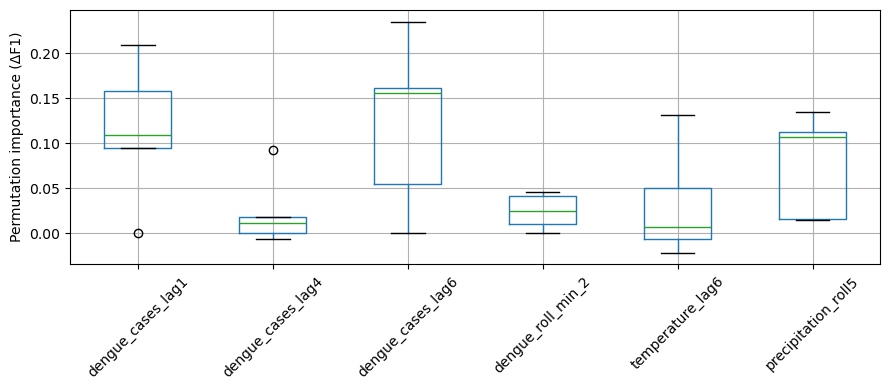

dengue_cases_lag6      0.121318
dengue_cases_lag1      0.114145
precipitation_roll5    0.076916
temperature_lag6       0.032237
dengue_roll_min_2      0.024490
dengue_cases_lag4      0.023052
dtype: float64


In [26]:
def permutation_across_folds(Xdf, y_arr, features, model_builder, n_splits=5, n_repeats=30):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    imp = {f: [] for f in features}
    for train_idx, val_idx in tscv.split(Xdf):
        X_tr = Xdf.iloc[train_idx][features].values
        y_tr = y_arr[train_idx]
        X_val = Xdf.iloc[val_idx][features].values
        y_val = y_arr[val_idx]
        m = model_builder()
        m.fit(X_tr, y_tr)
        res = permutation_importance(m, X_val, y_val, n_repeats=n_repeats, random_state=0, scoring='f1') # Shuffling and testing the model again
        for i,f in enumerate(features):
            imp[f].append(res.importances_mean[i])
    return imp

imp_dict = permutation_across_folds(train_df, y, WEATHER_FEATURES, build_xgb_deterministic, n_splits=5, n_repeats=30)
imp_df = pd.DataFrame({k: v for k,v in imp_dict.items()})
imp_df.describe().T.to_csv('perm_importance_stats.csv')
# boxplot
plt.figure(figsize=(9,4))
imp_df.boxplot(rot=45)
plt.ylabel('Permutation importance (ΔF1)')
plt.tight_layout()
plt.savefig('perm_importance_boxplot.png', dpi=150)
plt.show()
print(imp_df.mean().sort_values(ascending=False))


<h3>Hyperparameter Tuning</h3>

In [28]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'n_jobs': 1,
        'tree_method': 'hist'
    }
    tscv = TimeSeriesSplit(n_splits=4)
    f1s = []
    for train_idx, val_idx in tscv.split(weather_x):
        X_tr, X_val = weather_x.iloc[train_idx], weather_x.iloc[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        m = xgb.XGBClassifier(**params)
        m.fit(X_tr, y_tr,eval_set=[(X_val, y_val)], verbose=False)
        prob = m.predict_proba(X_val)[:,1]
        pred = (prob >= 0.5).astype(int)
        f1s.append(f1_score(y_val, pred))
    return np.mean(f1s)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) 
print('best params', study.best_params)

best_params = study.best_params # Saves the best hyperparameter

[I 2026-01-24 17:00:12,186] A new study created in memory with name: no-name-e03b7b25-c93d-4d7d-a3d7-9efbd5ed199c
[I 2026-01-24 17:00:12,637] Trial 0 finished with value: 0.5176095975661209 and parameters: {'n_estimators': 210, 'max_depth': 3, 'learning_rate': 0.0003715998867184044, 'subsample': 0.9067634050970491, 'colsample_bytree': 0.9831797494771506, 'reg_lambda': 0.15649767043411328}. Best is trial 0 with value: 0.5176095975661209.
[I 2026-01-24 17:00:14,271] Trial 1 finished with value: 0.5567023775150399 and parameters: {'n_estimators': 719, 'max_depth': 5, 'learning_rate': 0.00010500252194557283, 'subsample': 0.8123126584835301, 'colsample_bytree': 0.9781099999490881, 'reg_lambda': 0.0021849009619280195}. Best is trial 1 with value: 0.5567023775150399.
[I 2026-01-24 17:00:15,115] Trial 2 finished with value: 0.5255688076938432 and parameters: {'n_estimators': 274, 'max_depth': 8, 'learning_rate': 0.00028541577803015773, 'subsample': 0.9443137702213643, 'colsample_bytree': 0.774

best params {'n_estimators': 341, 'max_depth': 5, 'learning_rate': 0.012525584374631835, 'subsample': 0.7986532403140885, 'colsample_bytree': 0.9060803717099163, 'reg_lambda': 0.014811354333508189}


<h2>Validation & Evaluation</h2>

In [31]:
def build_xgb():
    return xgb.XGBClassifier(
        **best_params, # Uses the best parameters from the optuna hyperparameter
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=1
    )

baseline_df = df_lagged[['dengue_cases_lag4','dengue_cases_lag1','dengue_cases_lag6','dengue_roll_min_2']]
weather_x = pd.concat([df_lagged[['temperature_lag6','precipitation_roll5']],baseline_df],axis=1)

final_X = weather_x.copy()
final_y = y.copy()

final_model = build_xgb() # Retrains the model based on the whole training set, no more rolling-origin CV split
final_model.fit(final_X, final_y)

joblib.dump(final_model, "final_xgb_outbreak_model.joblib")
FINAL_FEATURES = list(final_X.columns) # Keep the final features' names

Final holdout metrics:
{'auc': 0.732741617357002, 'pr_auc': 0.5998104680614867, 'sens': 0.3076923076923077, 'prec': 0.6153846153846154, 'f1': 0.41025641025641024}


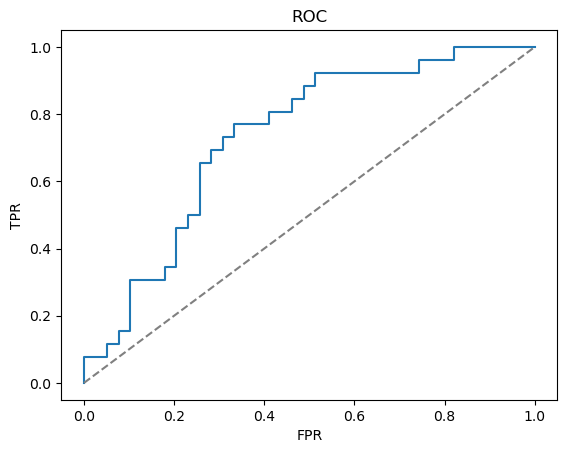

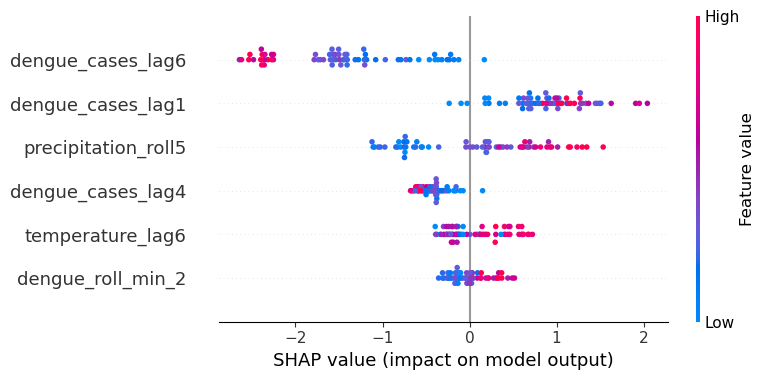

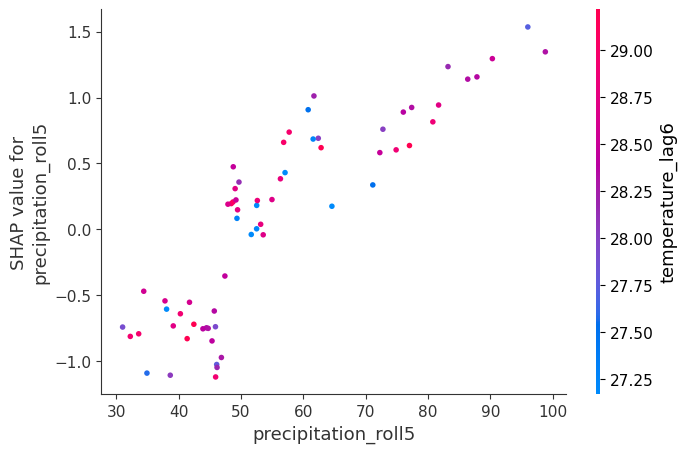

In [35]:
validation = df_validation.copy() 

# Recreating the finalized feature's engineered feature
validation['dengue_cases_lag4']=validation['dengue_cases'].shift(4)
validation['dengue_cases_lag1']=validation['dengue_cases'].shift(1)
validation['dengue_cases_lag6']=validation['dengue_cases'].shift(6)
validation['dengue_roll_min_2']=validation['dengue_cases_lag1'].rolling(window=2).min()

validation['precipitation_lag1']=validation['precipitation'].shift(1)
validation['precipitation_roll5']=validation['precipitation_lag1'].rolling(window=5).mean()

validation['temperature_lag6']=validation['temperature'].shift(6)

validation['q75_4w'] = validation['dengue_cases'].rolling(window=4, min_periods=1).quantile(0.75).shift(1)
validation['outbreak'] = (validation['dengue_cases'] > validation['q75_4w']).astype(int)

validation.dropna(inplace=True)

X_holdout = validation[FINAL_FEATURES].values
y_holdout = validation['outbreak'].values

probs = final_model.predict_proba(X_holdout)[:,1]
pred = (probs >= 0.5).astype(int)

# metrics
aucroc = roc_auc_score(y_holdout, probs)
prec, rec, _ = precision_recall_curve(y_holdout, probs)
prauc = auc(rec, prec)
sens = recall_score(y_holdout, pred)
prec_val = precision_score(y_holdout, pred)
f1_val = f1_score(y_holdout, pred)
print("Final holdout metrics:")
print(dict(auc=aucroc, pr_auc=prauc, sens=sens, prec=prec_val, f1=f1_val))

# ROC & PR plots
fpr, tpr, _ = roc_curve(y_holdout, probs)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.savefig('roc_holdout.png', dpi=150)
plt.show()
plt.close()

# SHAP for model evaluation
explainer = shap.TreeExplainer(final_model)
Xsamp = pd.DataFrame(X_holdout, columns=FINAL_FEATURES).sample(n=min(1000, len(X_holdout)), random_state=0)
shap_vals = explainer.shap_values(Xsamp) if hasattr(explainer, 'shap_values') else explainer(Xsamp).values
sv = shap_vals[1] if isinstance(shap_vals, list) else shap_vals
shap.summary_plot(sv, Xsamp, show=False)
plt.savefig('shap_summary_holdout.png', dpi=150)
shap.dependence_plot('precipitation_roll5', sv, Xsamp, interaction_index='temperature_lag6', show=False)
plt.savefig('shap_depend_precip_temp.png', dpi=150)


In [34]:
# Checking the best theshold for those data points
y_true = y_holdout

# Threshold sweep
ths = np.linspace(0,1,101)
rows = []
for t in ths:
    preds = (probs >= t).astype(int)
    sens = recall_score(y_true, preds, zero_division=0)
    prec = precision_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)
    rows.append((t, sens, prec, f1, preds.sum()))
df_th = pd.DataFrame(rows, columns=['threshold','sens','prec','f1','n_pred_pos'])
print(df_th.sort_values('sens', ascending=False).head(10))  # show high-sensitivity rows
print(df_th.sort_values('f1', ascending=False).head(10))   # show top F1 rows

# The best F1 threshold
best_f1 = df_th.loc[df_th['f1'].idxmax()]
print("Best-F1 threshold:", best_f1.to_dict())

   threshold      sens      prec        f1  n_pred_pos
0       0.00  1.000000  0.400000  0.571429          65
3       0.03  1.000000  0.440678  0.611765          59
1       0.01  1.000000  0.400000  0.571429          65
2       0.02  1.000000  0.412698  0.584270          63
4       0.04  0.961538  0.438596  0.602410          57
5       0.05  0.961538  0.462963  0.625000          54
6       0.06  0.923077  0.452830  0.607595          53
7       0.07  0.923077  0.470588  0.623377          51
8       0.08  0.923077  0.489796  0.640000          49
9       0.09  0.923077  0.533333  0.676056          45
    threshold      sens      prec        f1  n_pred_pos
9        0.09  0.923077  0.533333  0.676056          45
15       0.15  0.846154  0.550000  0.666667          40
14       0.14  0.846154  0.550000  0.666667          40
21       0.21  0.730769  0.612903  0.666667          31
19       0.19  0.807692  0.567568  0.666667          37
10       0.10  0.884615  0.534884  0.666667          43
11 